<a href="https://colab.research.google.com/github/laodar/MyBlocks/blob/master/PUbyGradW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sklearn

In [4]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14

In [6]:
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # Convert the original labels [0,1,2,3] to [0,1]
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

In [7]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

6000 data points and 2 features
3000 positive out of 6000 total


In [8]:
# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [9]:
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

300 positive out of 6000 total


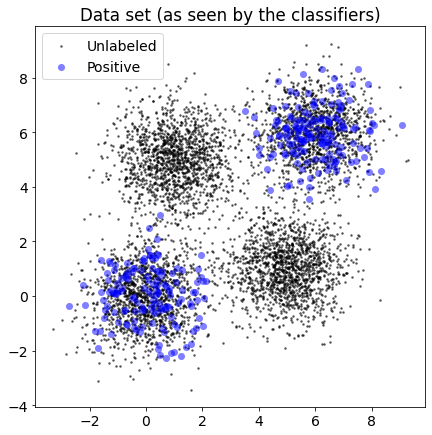

In [10]:
# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

In [11]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

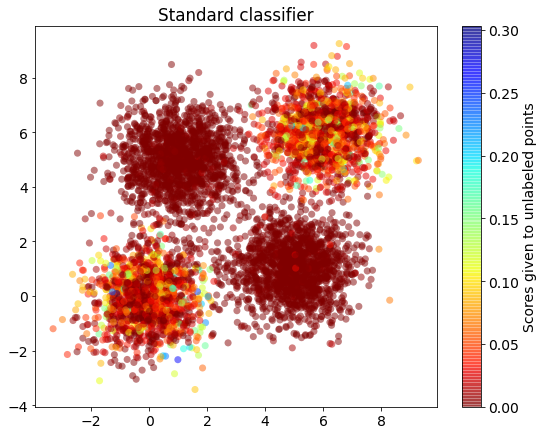

In [12]:
# Visualize this approach's results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

In [16]:
np.array(X[y==0]).shape, np.array(X[y==1]).shape

((5700, 2), (300, 2))

In [35]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(MLP, self).__init__()
    self.input_size = input_size
    self.hidden_size  = hidden_size
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
    self.relu = torch.nn.LeakyReLU()
    self.fc2 = torch.nn.Linear(self.hidden_size, 1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    hidden = self.fc1(x)
    relu = self.relu(hidden)
    output = self.fc2(relu)
    output = self.sigmoid(output)
    return output

In [36]:
def gradient_norm(model, x_):
  x = Variable(x_, requires_grad=True)
  fx = model(x)
  grad_x = autograd.grad(outputs=fx, inputs=[x], grad_outputs=[torch.ones(fx.size()).cuda()], create_graph=True, retain_graph=True, only_inputs=True)[0]
  g_x = grad_x.contiguous().view(grad_x.size()[0], -1)
  gradient_norm = g_x.norm(2, dim=1)
  return gradient_norm

In [37]:
def attention(sim, t=1.0, dim=-1):
  logits = torch.exp(sim * t)
  return logits / logits.sum(dim=dim, keepdims=True)

def ReweightedBEC(s0, w0, s1, w1):
  EPS = 1e-3
  loss = - torch.sum(w0 * torch.log(1.0 - s0 + EPS)) - torch.sum(w1 * torch.log(s1 + EPS))
  return loss

def normalize(w):
  return w / w.sum()

  0%|          | 0/100 [00:00<?, ?it/s]

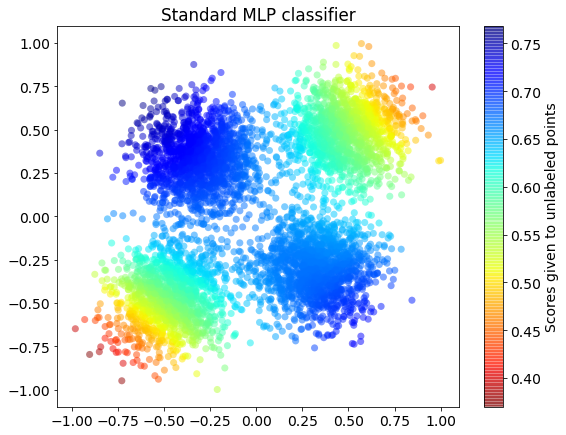

 10%|█         | 10/100 [00:03<00:24,  3.67it/s]

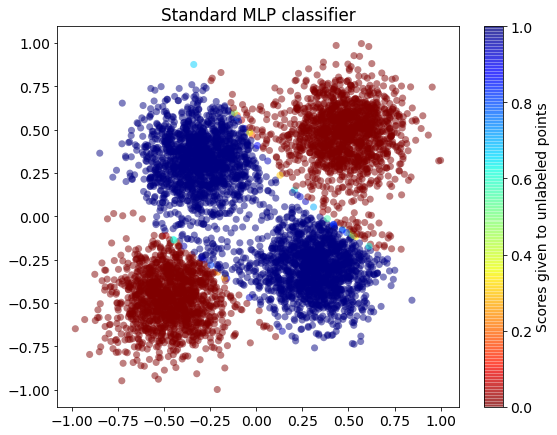

 20%|██        | 20/100 [00:06<00:21,  3.72it/s]

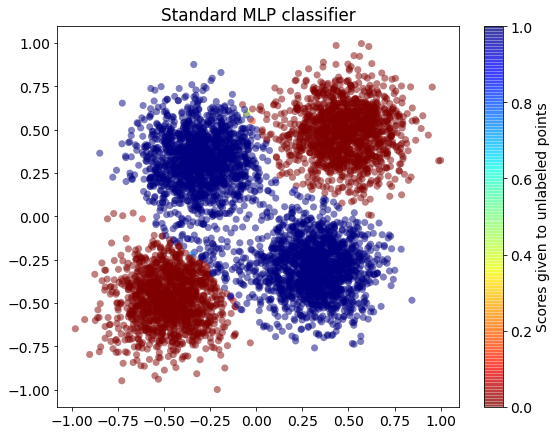

 30%|███       | 30/100 [00:09<00:18,  3.70it/s]

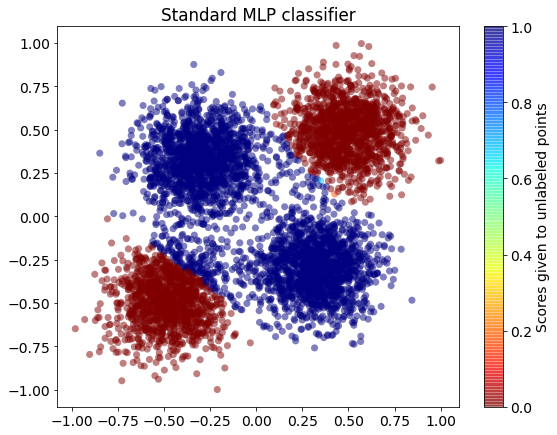

 40%|████      | 40/100 [00:12<00:16,  3.63it/s]

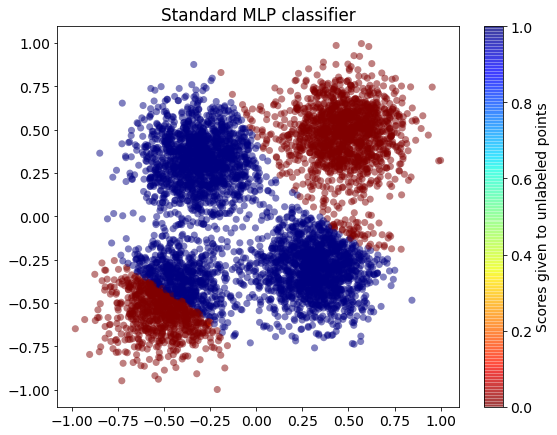

 50%|█████     | 50/100 [00:15<00:13,  3.65it/s]

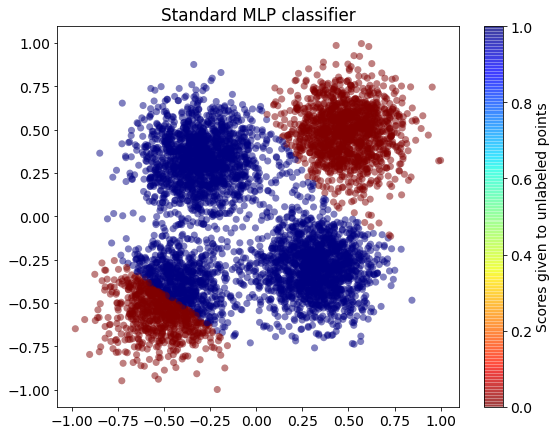

 60%|██████    | 60/100 [00:18<00:11,  3.59it/s]

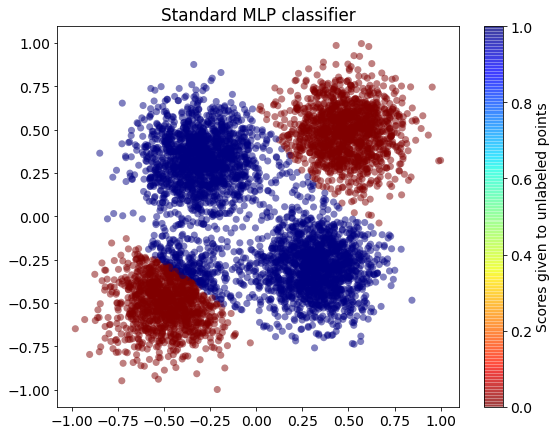

 70%|███████   | 70/100 [00:21<00:08,  3.60it/s]

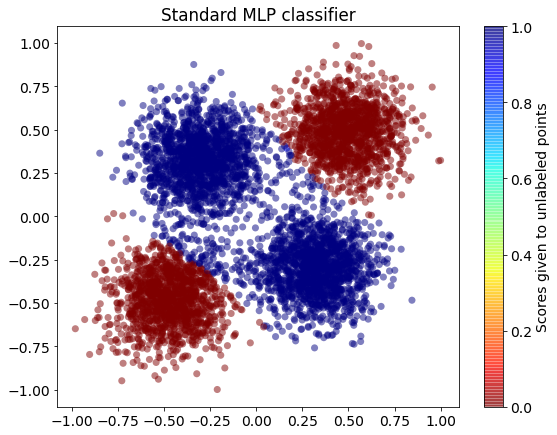

 80%|████████  | 80/100 [00:24<00:05,  3.77it/s]

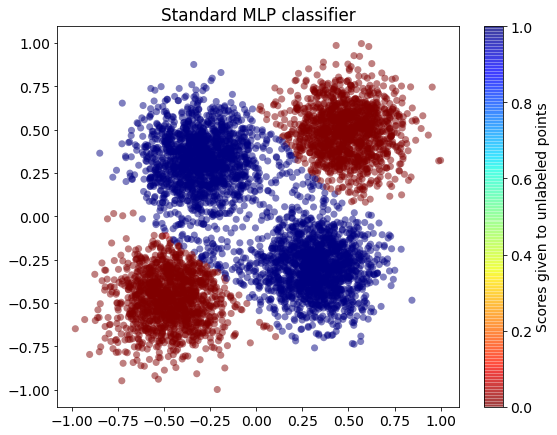

 90%|█████████ | 90/100 [00:27<00:02,  3.66it/s]

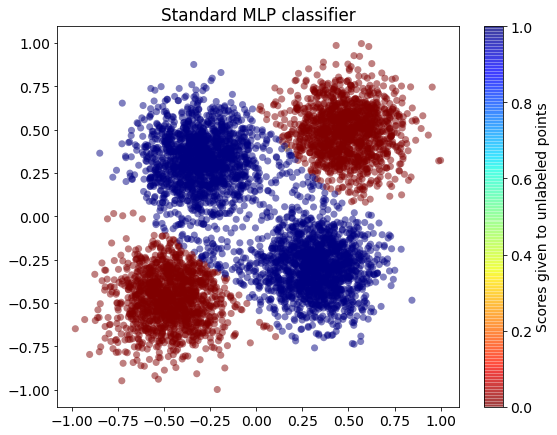

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


In [40]:
# Traditional classification loss
import torch
from tqdm import tqdm
model = MLP(2, 256).cuda()
bz = 32
XU = torch.tensor(np.array(X[y==0]).astype(np.float32)).cuda()
XP = torch.tensor(np.array(X[y==1]).astype(np.float32)).cuda()
XU = 2.0*(XU - XU.min())/(XU.max()-XU.min())-1.0
XP = 2.0*(XP - XP.min())/(XP.max()-XP.min())-1.0
optimizer = torch.optim.AdamW(model.parameters(), 
                lr=0.01, 
                betas=(0.9, 0.999), 
                weight_decay=1e-8)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                          max_lr=0.01,
                          total_steps=10000,
                          cycle_momentum=True,
                          pct_start=0.1)

for ep in tqdm(range(100)):
  XU = XU[torch.randperm(XU.size(0))]
  XP = XP[torch.randperm(XP.size(0))]
  for i in range(100):
    idxp = np.random.randint(0, XP.size(0)//bz, 1)[0]
    idxu = np.random.randint(0, XU.size(0)//bz, 1)[0]    
    xp = XP[idxp*bz:idxp*bz+bz]
    xu = XU[idxu*bz:idxu*bz+bz]
    predp = model(xp)
    predu = model(xu)
    wp = normalize(torch.ones_like(predp))
    wu = normalize(torch.ones_like(predu))
    loss_cls = ReweightedBEC(predp, wp, predu, wu)
    loss_cls.backward()
    optimizer.step()
    lr_scheduler.step()
  if ep % 10 == 0:
    PredU = model(XU)
    # Visualize this approach's results
    plt.rcParams['figure.figsize'] = 9,7
    plt.scatter(
        XU[:, 0].cpu().detach().numpy(), 
        XU[:, 1].cpu().detach().numpy(), 
        c = PredU.cpu().detach().numpy(), 
        linewidth = 0, 
        s = 50, 
        alpha = 0.5, 
        cmap = 'jet_r'
    )
    plt.colorbar(label='Scores given to unlabeled points')
    plt.title('Standard MLP classifier')
    plt.show()
